<h1>A. Data Collection & Exploration

<h2>Import libraries

In [40]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

<h2>Import dataset

In [2]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model.head()
# df_model.Stay

# for x in df_model.Stay:
#     if df_model.Stay[x] != 0:
#       print(df_model.Stay[x])
#     else:
#       message ="no employee stay find!";
#       print(message)
#       break;

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'promotion_last_5years'

In [5]:
#choose the treatment variable
target = "left"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
3,average_montly_hours,215
0,satisfaction_level,92
1,last_evaluation,65
4,time_spend_company,8
2,number_project,6
5,Work_accident,2
6,left,2
7,promotion_last_5years,2


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['average_montly_hours']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Department
sales 4140
accounting 767
hr 739
technical 2720
support 2229
management 630
IT 1227
product_mng 902
marketing 858
RandD 787

 salary
low 7316
medium 6446
high 1237


<h2>Replace Yes or No to 1 or 0

In [11]:
# df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
# df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Data

In [12]:
df_model[[treat,target]].head()

,promotion_last_5years,left
id,,
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


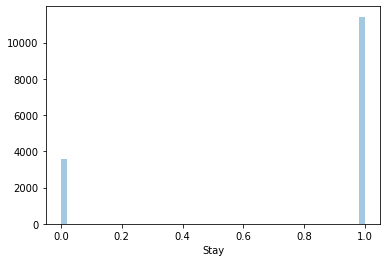

In [13]:
df_model = df_model.rename(columns={"left": "Stay"})
df_model.Stay = df_model.Stay.replace({0:1, 1:0})
sns.distplot(a=df_model.Stay, hist=True,kde=False)

<h2>Invert Target Value(Churn to Stay)

In [14]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total T,total C,total CR,total CN,total TR,total TN
0,14999,319,14680,10240,2384,36,307


In [15]:
# sns.distplot(a=df_model.Stay, hist=True,kde=False)

B.6. Inverting data from column 'Stay':[0 0 0 0 0 0 0 0 0 0] ... 
Inverted result named 'stay':[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... 
Column 'left' has been successfully replaced by new column 'stay'!


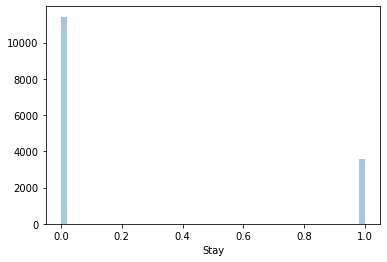

In [16]:
#setup the target column to be inverted and prepare empty array named inverted
input_data = df_model.Stay
inverted = []
print ("B.6. Inverting data from column '{}':{} ... ".format(input_data.name,df_model.Stay.values[:10]))

#inverting through all datas in column
for i in range(len(input_data)):
    inverted.append(1 - input_data[i])
print ("Inverted result named 'stay':{} ... ".format(inverted[:10]) )

#add new column stay and remove column left
df_model['Stay']=inverted
print ("Column 'left' has been successfully replaced by new column 'stay'!")

#check the result
sns.distplot(a=df_model.Stay, hist=True,kde=False)

In [17]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total C,total T,total CR,total CN,total TR,total TN
0,14999,14680,319,2384,10240,307,36


<h2>Define columns to Label encode

In [18]:
# df_model[object_cols].head()
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [19]:
#choose a column with wide range to be clusterred
label_cols = ['salary']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [20]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['salary']
>>label encoding finished


,salary
id,
0,1
1,2
2,2
3,1
4,1


<h2>Data cleaning

In [21]:
#DROP unused columns
# df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [22]:
#function to order clusters
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final

In [23]:
# #preparing float columns to cluster
# print('Clustering columns:',cluster_cols)
# #creating the clusters
# for col in cluster_cols:
#     col_cluster = col + "_cluster"
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(df_model[[col]])
#     df_model[col_cluster] = kmeans.predict(df_model[[col]])
#     #order the clusters
#     df_model = order_cluster(col_cluster, col, df_model, True)
# print('>>Cluster succeeded!')
# #dropping columns that have been clustered
# df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours' 'time_spend_company' 'Work_accident' 'Stay'
 'promotion_last_5years' 'salary' 'Department_IT' 'Department_RandD'
 'Department_accounting' 'Department_hr' 'Department_management'
 'Department_marketing' 'Department_product_mng' 'Department_sales'
 'Department_support' 'Department_technical']
>>One Hot Encoding succeeded!


In [24]:
df_model

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
id,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,2,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,2,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


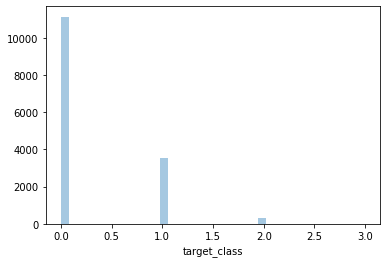

In [25]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Treatment Identification

In [26]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
pd.DataFrame(round(correlation.Stay.sort_values() * 100,2)).reset_index()

,index,Stay
0,satisfaction_level,-38.84
1,Work_accident,-15.46
2,promotion_last_5years,-6.18
3,Department_RandD,-4.66
4,Department_management,-4.60
5,Department_product_mng,-1.10
6,Department_IT,-1.09
7,salary,-0.13
8,Department_marketing,-0.09
9,last_evaluation,0.66


<Figure size 216x1440 with 0 Axes>

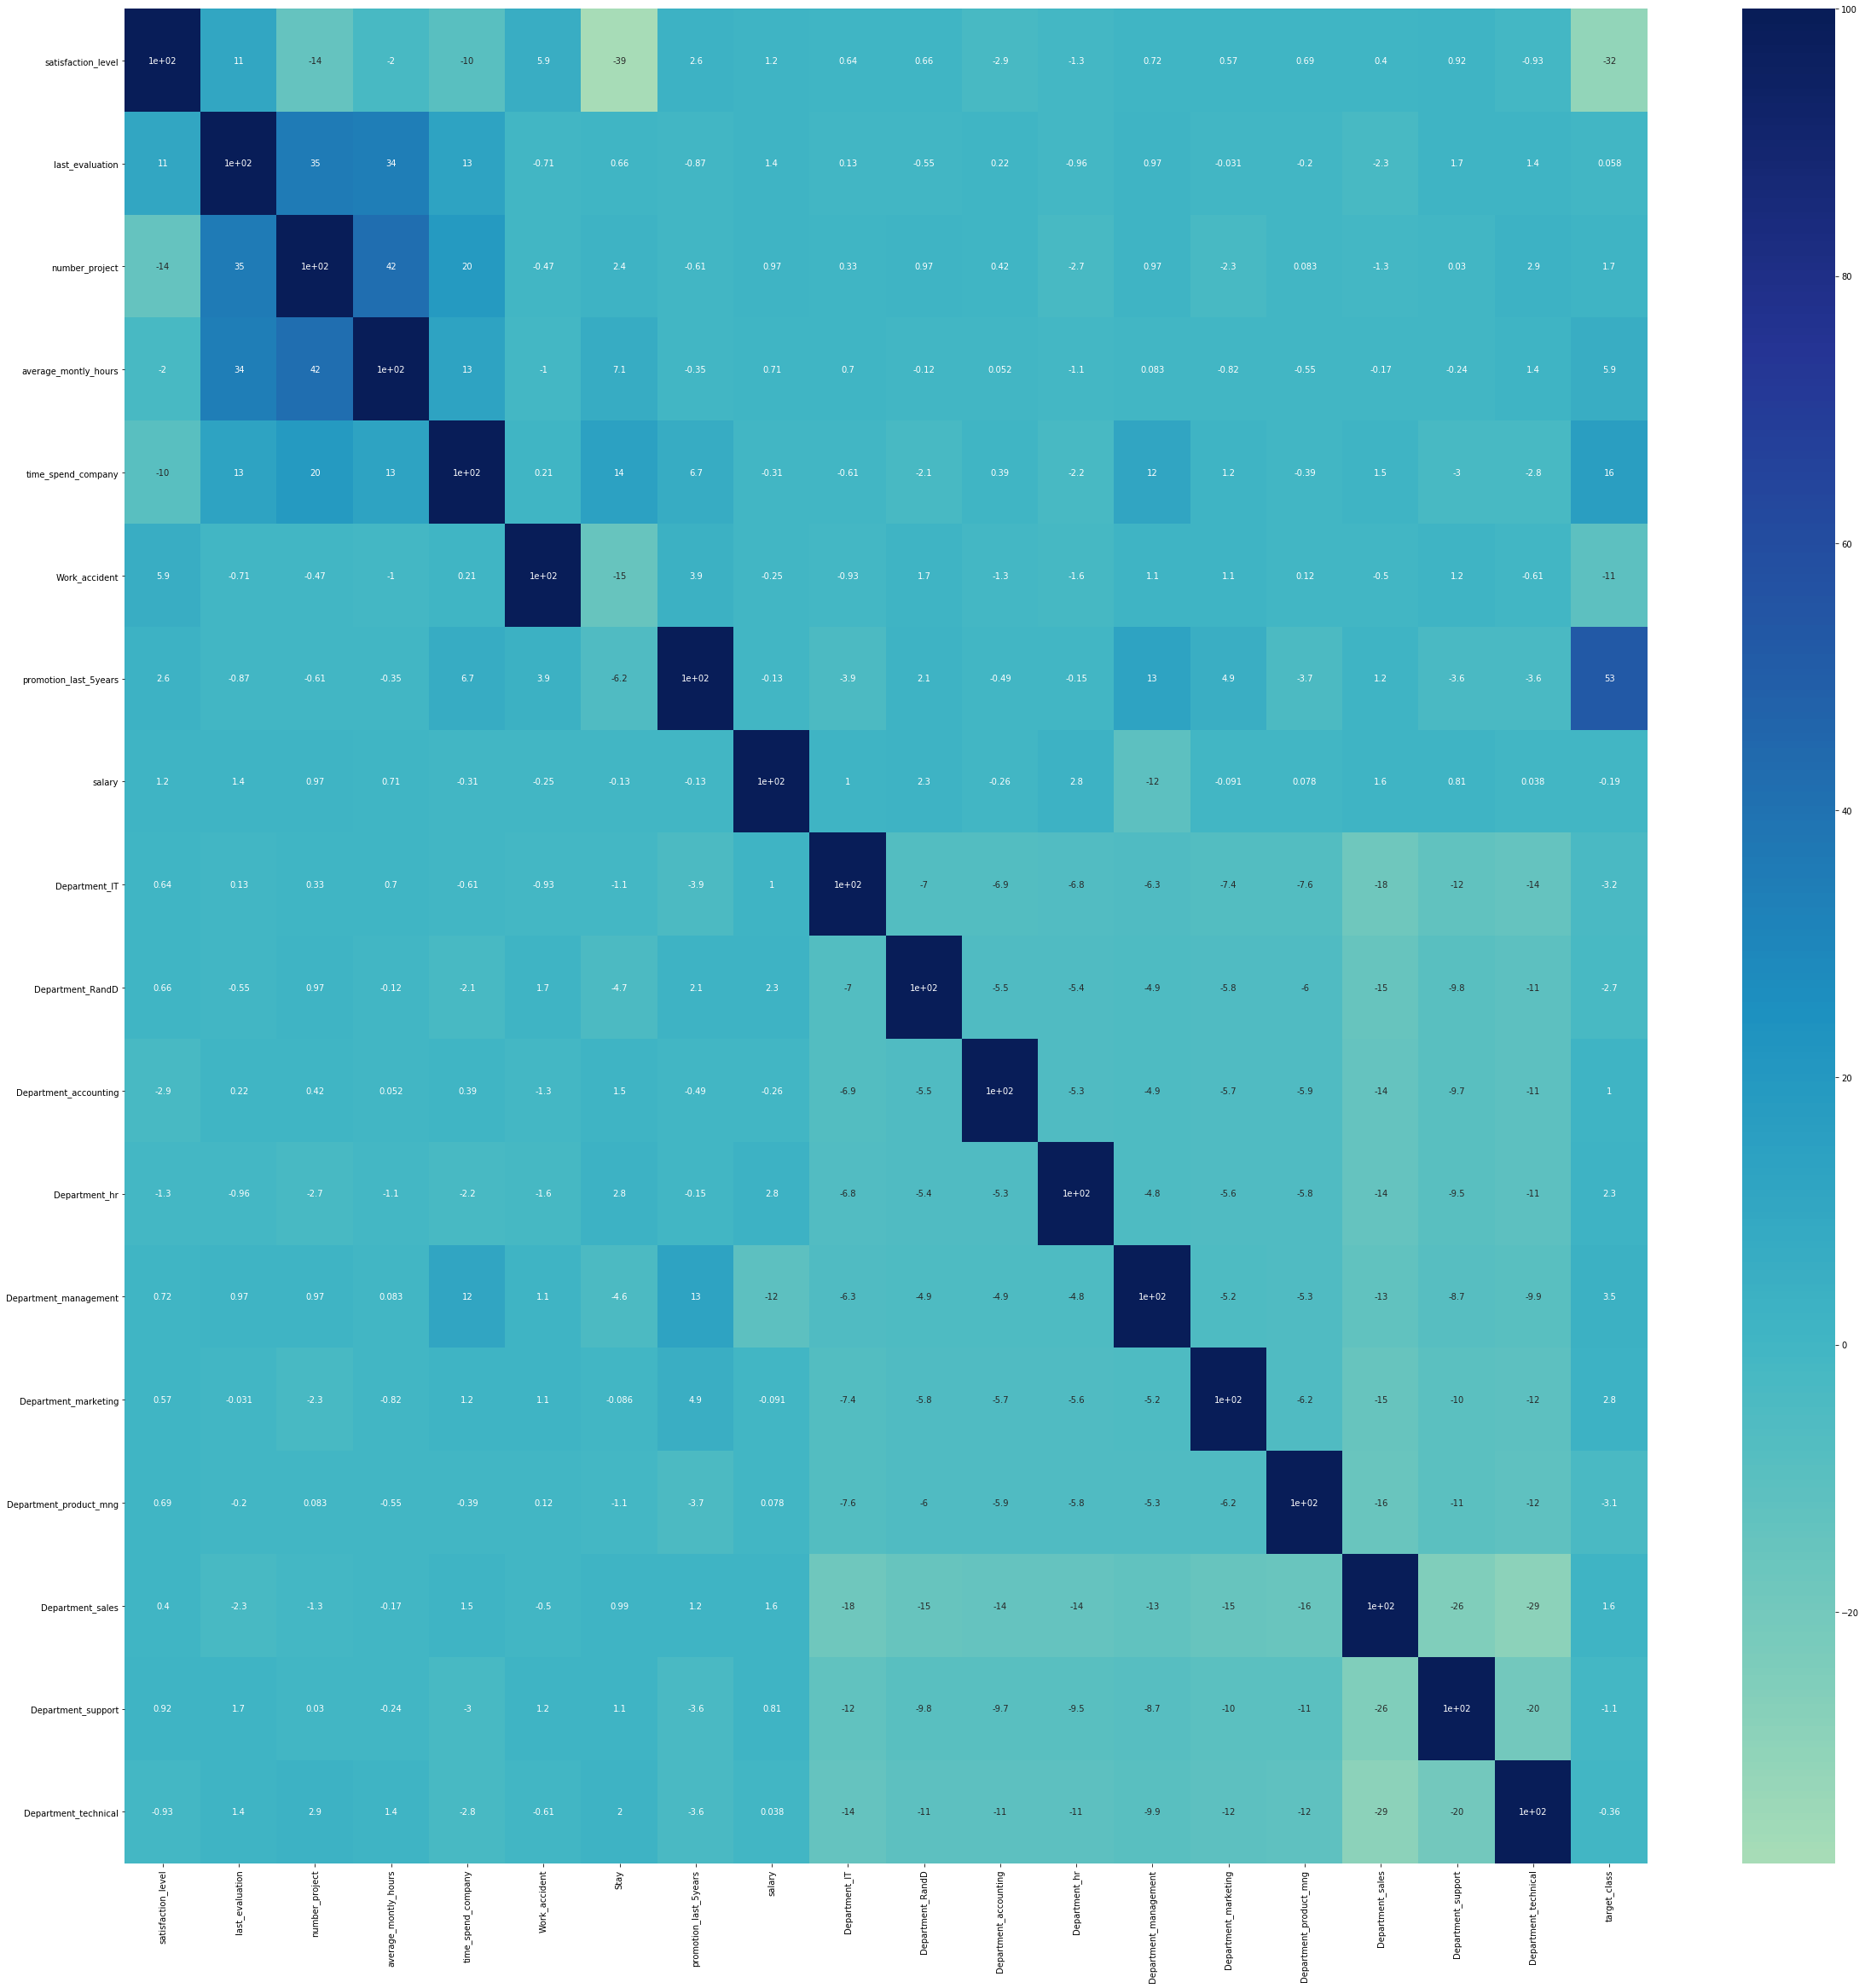

<Figure size 216x1440 with 0 Axes>

In [27]:
#measure the correlation of Employees who stay
treatment_corr_matrix = df_model.corr(method ='pearson')
#plot the data
plt.figure(figsize=(40,40))
corr = pd.DataFrame(treatment_corr_matrix.drop(labels=['Stay', 'target_class'])* 100)
sns.heatmap(corr, annot=True, center=0, cmap="YlGnBu")
plt.figure(figsize=(3,20))

In [28]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))

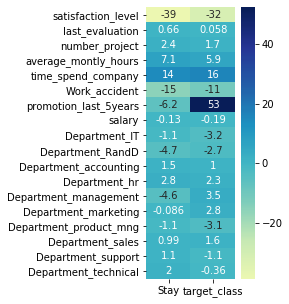

In [29]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))
#plot features that correlated with stay and target class
plt.figure(figsize=(2,5))
sns.heatmap(treatment_corr_table*100, annot=True, center=0, cmap="YlGnBu")

Text(0.5, 1, 'Top 5 Correlation')

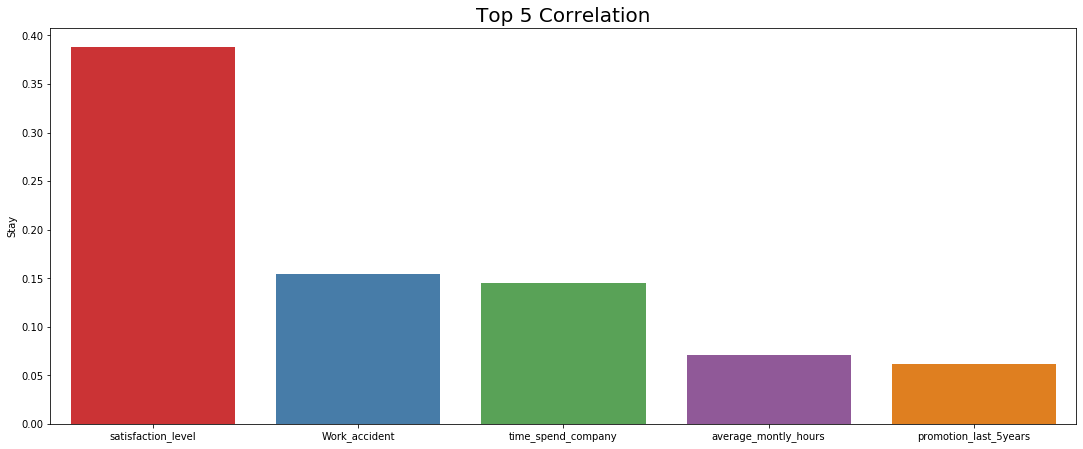

In [30]:
#define what column to drop
treat_matrix = treatment_corr_table.copy()
treat_matrix = treat_matrix.abs()*100 < 0
treat_matrix['and'] = treat_matrix.all(axis = 1)
target_labels = [treat, 'target_class','Stay']
#define what column to drop
drop_both = treat_matrix.index[treat_matrix['and'] == True].tolist()
drop_both.extend(target_labels)
drop_uplift = treat_matrix.index[treat_matrix['target_class'] == True].tolist()
drop_uplift.extend(target_labels)
drop_stay = treat_matrix.index[treat_matrix['Stay'] == True].tolist()
drop_stay.extend(target_labels)
# find the largest corr and plot it
largest_corr = treatment_corr_table.Stay.abs().nlargest(5)
largest = sns.barplot(y=largest_corr,x=largest_corr.index, palette='Set1')
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=1.5)
plt.title('Top 5 Correlation',y=1, fontsize=20)

<h2>Create new dataframe for churn and uplift

In [31]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

    target_class  Stay  promotion_last_5years
id                                           
0              1     1                      0
1              1     1                      0
2              1     1                      0
3              1     1                      0
4              1     1                      0


<h1> Modeling

<h2> Set Labels

In [32]:
#create features
X = df_model
#create labels for churn target
y_stay = df_model.Stay
#create labels for treatment
t = df_model[treat]

<h2>Churn Prediction

In [33]:
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y_stay, test_size=0.3, random_state=42, stratify = t)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_stay = xgb.XGBClassifier().fit(X_train.drop(drop_stay,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_stay = xgb_model_stay.predict(X_test.drop(drop_stay,axis=1))
overall_proba_stay = xgb_model_stay.predict_proba(X_test.drop(drop_stay,axis=1))
# put result in dataframe
df_data_churn = X_test
df_data_churn['p_stay'] = overall_predict_stay
df_data_churn['stay_score'] = overall_proba_stay[:,0]


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [34]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_stay)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.16%


In [35]:
confusion = confusion_matrix(y_test, overall_predict_stay)
tn, fp, fn, tp = confusion.ravel()
confusion = pd.DataFrame(confusion, columns = ['True','False'], index = ['Positive','Negative'])
confusion

,True,False
Positive,3391,45
Negative,83,981


<h2>Uplift Modeling - Four Quadrant

In [36]:
#create labels
y_target_class = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y_target_class, test_size=0.3, random_state=42, stratify=t)

In [37]:
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_target_class = xgb.XGBClassifier()
xgb_model_target_class = xgb_model_target_class.fit(X_train.drop(drop_uplift,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_target_class = xgb_model_target_class.predict(X_test.drop(drop_uplift,axis=1))
overall_proba_target_class=xgb_model_target_class.predict_proba(X_test.drop(drop_uplift,axis=1))

# insert predicted target to uplift dataframe
df_data_uplift = X_test
df_data_uplift['p_target'] = overall_predict_target_class

# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba_target_class[:,0] 
df_data_uplift['proba_CR'] = overall_proba_target_class[:,1] 
df_data_uplift['proba_TN'] = overall_proba_target_class[:,2] 
df_data_uplift['proba_TR'] = overall_proba_target_class[:,3]

#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')

#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [38]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_target_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.18%


In [42]:
multilabel_confusion_matrix(y_test, overall_predict_target_class)

array([[[ 993,  160],
        [  50, 3297]],

       [[3392,   51],
        [  80,  977]],

       [[4405,    6],
        [  80,    9]],

       [[4493,    0],
        [   7,    0]]], dtype=int64)

<h2> creating data for Ranking and Evaluation

In [ ]:
df_data_churn = df_data_churn[['Stay', treat, 'target_class', 'p_stay', 'stay_score']]
df_data_uplift = df_data_uplift[['Stay', treat, 'target_class', 'p_target', 'uplift_score']]

<h2>Rank data from Churn prediction

In [ ]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")

df_data_churn_all = df_data_churn.copy()
df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=True)
df_data_churn_all = df_data_churn_all.reset_index()

#treatment only
df_data_churn = df_data_churn[df_data_churn.target_class > 1]
print("Ranking data for Churn Prediction with control not included")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=True)
df_data_churn = df_data_churn.reset_index()

<h2>Rank data from Uplift prediction

In [ ]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all = df_data_uplift.copy()
df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
df_data_uplift_all = df_data_uplift_all.reset_index()

#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift with control not included")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=False)
df_data_uplift = df_data_uplift.reset_index()

In [ ]:
#define basic variable c=cost, j=decile_count
c=0
j=round(len(df_data_churn)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CUMP1 = CPMP1.copy()

#1
b1=82000
i1=16666
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

CP_list1, CU_list1 = [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Variables for churn Prediction 
    #retained within the segment
    r = sum(df_data_churn.target_class[0:m]==3)
    #not retained within the segment
    nr =  sum(df_data_churn.target_class[0:m]==2)
    #False retained within the segment
    fr = sum(df_data_churn.target_class[0:m]==1)
        
    #Variables for Uplift Modelling
    u_r=sum(df_data_uplift.target_class[0:m]==3)
    u_nr=sum(df_data_uplift.target_class[0:m]==2)
    u_fr=sum(df_data_uplift.target_class[0:m]==1)
    
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns)) 
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)

In [ ]:
#create new column method = churn_prediction
CPMP1['method'] = 'MPC'

#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'MPU'
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')
result_mp1

In [ ]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('MPU',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Treatment and Control

In [ ]:
#prepare 3 dataframe for CPMPU
CPMPU = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CUMPU, PUMPU = CPMPU.copy(), CPMPU.copy()
CP_list, CU_list, PU_list = [], [], []

#prepare dataframe for QINI Curves
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
QP = QU.copy()
QU_list, QC_list, QP_list = [], [], []
p4_1=(b1-i1)

j = 10
k = math.ceil(len(df_data_churn_all)/j)
for i in range(j):
    m=(i+1)*k 
    
#     #Input total actual control and treatment data
#     churn_control_count = sum(df_data_churn_all[treat]==0)
#     churn_treatment_count = sum(df_data_churn_all[treat]==1)
#     #Input total actual control and treatment data
#     uplift_control_count = sum(df_data_uplift_all[treat]==0)
#     uplift_treatment_count = sum(df_data_uplift_all[treat]==1)
    #Actual Qini Churn - Input Data
    RC_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==0))
    RT_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==1))
    NC_churn = sum(df_data_churn_all[treat][0:m]==0)
    NT_churn = sum(df_data_churn_all[treat][0:m]==1)
    #Actual Qini Uplift - Input Data
    RC_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==0))
    RT_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==1))
    NC_uplift = sum(df_data_uplift_all[treat][0:m]==0)
    NT_uplift = sum(df_data_uplift_all[treat][0:m]==1)
    #Predicted Qini Uplift - Input Data
    RC_predicted = sum(df_data_uplift_all.p_target[0:m]==1)
    RT_predicted = sum(df_data_uplift_all.p_target[0:m]==3)
    NC_predicted = sum(df_data_uplift_all.p_target[0:m]<=1)
    NT_predicted = sum(df_data_uplift_all.p_target[0:m]>=2)
    
#     pilih salah satu metode:    
#     QINI_c = ((RT_churn/churn_treatment_count) - (RC_churn/churn_control_count))
#     QINI_u = ((RT/uplift_treatment_count) - (RC/uplift_control_count))   
    #Calculate QINI
    QINI_c = (RT_churn-((RC_churn*NT_churn)/NC_churn))
    QINI_u = (RT_uplift-((RC_uplift*NT_uplift)/NC_uplift))
    QINI_p = (RT_predicted/2-((RC_predicted*NT_predicted)/NC_predicted)*2)
    #Append to list
    QC_list.append(pd.Series([((i+1)/10), QINI_c], index=QC.columns))
    QU_list.append(pd.Series([((i+1)/10), QINI_u], index=QU.columns))
    QP_list.append(pd.Series([((i+1)/10), QINI_p], index=QU.columns))
    
    #Calculate MPU 
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3) 
    #Qini & TR for churn prediction
    CP_profit = ((QINI_c*p4_1) - TR_churn)/m
    #Qini & TR for uplift prediction
    CU_profit = ((QINI_u*p4_1) - TR_uplift)/m
    #Qini & TR for uplift prediction
    PU_profit = ((QINI_p*p4_1) - RT_predicted)/m
    #Append to list
    CP_list.append(pd.Series([((i+1)/10), QINI_c, TR_churn, CP_profit], index=CPMPU.columns))  
    CU_list.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, CU_profit], index=CUMPU.columns))
    PU_list.append(pd.Series([((i+1)/10), QINI_p, RT_predicted, PU_profit], index=CUMPU.columns))
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
QP = QP.append(QP_list , ignore_index=True)
# add q0 into dataframe for Qini Curve
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)
QP = pd.concat([q0, QP]).reset_index(drop = True)

# append MPU list into dataframe    
CPMPU = CPMPU.append(CP_list , ignore_index=True)
CUMPU = CUMPU.append(CU_list , ignore_index=True)
PUMPU = PUMPU.append(PU_list , ignore_index=True)
# add q0 into MPU dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
CPMPU = pd.concat([q0, CPMPU]).reset_index(drop = True)
CUMPU = pd.concat([q0, CUMPU]).reset_index(drop = True)
PUMPU = pd.concat([q0, PUMPU]).reset_index(drop = True)

In [ ]:
CPMPU['Churn Prediction MPU'] = CPMPU['mpu']
CPMPU['Uplift Prediction MPU'] = CUMPU['mpu']
CPMPU['Predicted Uplift MPU'] = PUMPU['mpu'] 
CPMPU = CPMPU.drop(['mpu', 'QINI', 'TR'], axis=1)
CPMPU

In [ ]:
sns.lineplot(x=CPMPU.n, y=CPMPU['Churn Prediction MPU'], label='Churn Prediction', color='blue')
sns.lineplot(x=CPMPU.n, y=CPMPU['Uplift Prediction MPU'], label='Uplift Modelling', color='red')
# sns.lineplot(x=CPMPU.n, y=CPMPU['Predicted Uplift MPU'], label='Predicted Uplift Modelling', color='green')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [ ]:
QP = QP.rename(columns={"uplift": "Predicted Uplift QINI"})
QP['Actual Uplift QINI'] = QU['uplift']
QP['Actual Churn QINI'] = QC['uplift']
QP

In [ ]:
random = np.linspace(QP['Predicted Uplift QINI'][0],QP['Predicted Uplift QINI'][j],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QP.n, y=QP['Predicted Uplift QINI'], label="Uplift Qini Prediction", color="green")
sns.set_style("whitegrid")
plt.title('Predicted QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [ ]:
random = np.linspace(QP['Actual Uplift QINI'][0],QP['Actual Uplift QINI'][10],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QC.n, y=QC.uplift, label="Churn Prediction", color="blue")
sns.lineplot(x=QU.n, y=QU.uplift, label="Uplift Prediction", color="red")
sns.set_style("whitegrid")
plt.title('Actual QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Pylift

In [ ]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

pylift modelling

In [ ]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [ ]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [ ]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [ ]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df